## End member mixing analysis (EMMA) to determine streamflow source contributions

### Principal components analysis using conservative tracers using the python scikit-learn library.​

#### Here we started with solute data from Hungerford Brook late winter/early spring flow events captured with ISCOs. Data include:
- ICP-OES (Al, Ca, Cu, Fe, K, Mg, Mn, Na, P, Zn, Si
- IC and total elemental analyser data (Cl, SO4, NO3, PO4, TOC, DIN)
- Stable isotopes (dD, d18O)

Data are from the BREE OneDrive directory (Watershed Data>1_Projects>EMMA>Working file for MATLAB 2023)

- For HB and WB 2022 timeseries, 17 parameters total
- For HB, 5 were found to be relatively conservative: Cl, Ca, Na, Si, and Mg
- See "bivariates" notebook for those plots

The linear regression model is fitted for each conservative tracer using the first two principal components as the independent variables. The contributions are then normalized to sum to 1 for each sample. The resulting dataframe streamflow_with_contributions contains the original streamflow data along with the contributions of each endmember.

In [1]:
import os
os.chdir("/home/millieginty/Documents/git-repos/EMMA/")

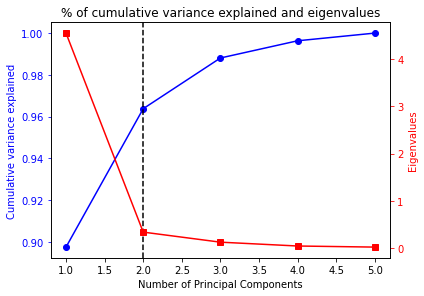

In [2]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data from the CSV file
data = pd.read_csv("data/Data_for_EMMA_2022_HB.csv")

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_data = data[selected_parameters]

# Standardize the data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data)

# Remove rows with any values that are not finite
scaled_data = scaled_data[numpy.isfinite(scaled_data).all(1)]

# Apply PCA
pca = PCA()  # Don't specify the number of components for now
pca_result = pca.fit_transform(scaled_data)

# Plot the percentage of cumulative variance explained on the primary y-axis
fig, ax1 = plt.subplots()

ax1.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), 
         marker='o', color='blue', label='Cumulative Variance Explained')
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Cumulative variance explained', color='blue')
ax1.tick_params('y', colors='blue')

# Plot a horizonal line at explain variance >80%, satifying the Christopherson & Hooper (1992) rule
ax1.axvline(x=2, color='black', linestyle='--')

# Create a second y-axis for eigenvalues
ax2 = ax1.twinx()
ax2.plot(range(1, len(pca.explained_variance_) + 1), 
         pca.explained_variance_, 
         marker='s', color='red', linestyle='-', label='Eigenvalues')
ax2.set_ylabel('Eigenvalues', color='red')
ax2.tick_params('y', colors='red')

# Plot a horizonal line at eigenvalues > 1, satifying the 'retain all ev >1 rule' (Hooper, 2003)
#ax2.axhline(y=1, color='black', linestyle='-')

# Display the legend
fig.tight_layout()
#fig.legend(loc='upper left', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.title('% of cumulative variance explained and eigenvalues')
plt.show()

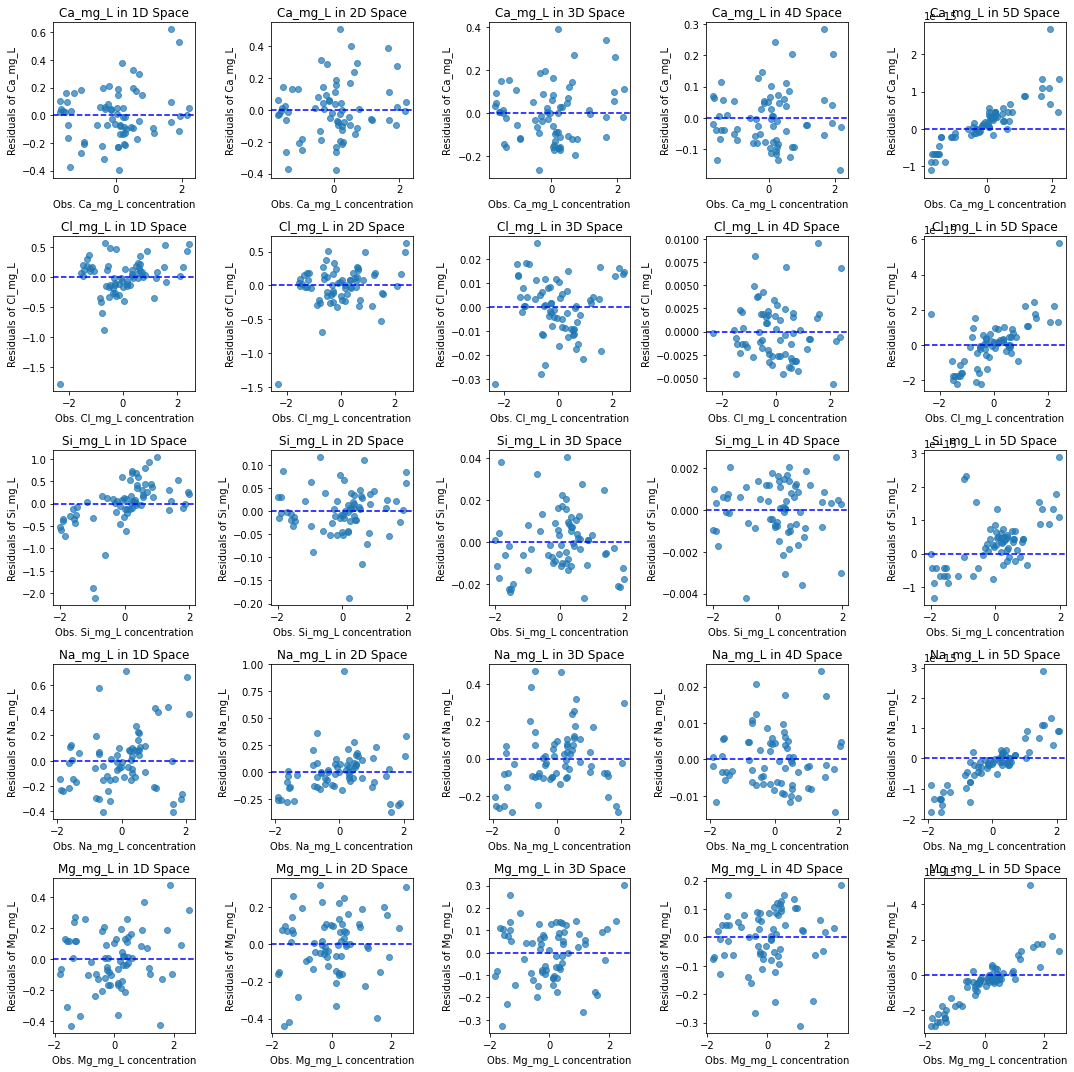

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data from the CSV file
data = pd.read_csv("data/Data_for_EMMA_2022_HB.csv")

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_data = data[selected_parameters]

# Standardize the data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data)

# Apply PCA
pca = PCA()  # Don't specify the number of components for now
pca_result = pca.fit_transform(scaled_data)

# Define the number of dimensions to consider
num_dimensions = range(1, len(selected_parameters) + 1)

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

# Plot residuals for each tracer in different mixing spaces
for i, tracer in enumerate(selected_parameters):
    for j, dim in enumerate(num_dimensions):
        # Project data onto the selected dimensions
        pca_result_subset = pca_result[:, :dim]
        
        # Reconstruct the standardized data from the selected dimensions
        reconstructed_data = np.dot(pca_result_subset, pca.components_[:dim, :])
        
        # Calculate residuals for the tracer
        residuals = scaled_data[:, i] - reconstructed_data[:, i]
        
        # Plot residuals against observed concentrations for each tracer
        ax = axes[i, j]
        ax.scatter(scaled_data[:, i], residuals, alpha=0.7, label=f'{tracer} Residuals vs observed')
        ax.axhline(y=0, color='blue', linestyle='--', label='Residual = 0')
        ax.set_title(f'{tracer} in {dim}D Space')
        ax.set_xlabel(f'Obs. {tracer} concentration')
        ax.set_ylabel(f'Residuals of {tracer}')
        #ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Once we have a specific number of components in mind, we can modify the n_components parameter when creating the PCA object:

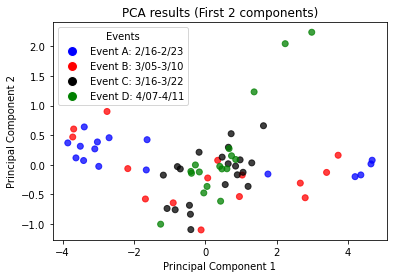

In [4]:
# Load the data from the CSV file
data = pd.read_csv("data/Data_for_EMMA_2022_HB.csv")

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_data = data[selected_parameters]

# Standardize the data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data)

# Apply PCA
pca = PCA(n_components=2)  # Specify the number of components
pca_result = pca.fit_transform(scaled_data)

# Add a column for the event based on the date
data['Event'] = 'Unknown'
data.loc[(data['Date'] >= '2022-02-16') & (data['Date'] <= '2022-02-23'), 'Event'] = 'Event A: 2/16-2/23'
data.loc[(data['Date'] >= '2022-03-05') & (data['Date'] <= '2022-03-10'), 'Event'] = 'Event B: 3/05-3/10'
data.loc[(data['Date'] >= '2022-03-16') & (data['Date'] <= '2022-03-22'), 'Event'] = 'Event C: 3/16-3/22'
data.loc[(data['Date'] >= '2022-04-07') & (data['Date'] <= '2022-04-11'), 'Event'] = 'Event D: 4/07-4/11'

# Define colors for each event
event_colors = {'Event A: 2/16-2/23': 'blue', 'Event B: 3/05-3/10': 'red', \
                'Event C: 3/16-3/22': 'black', 'Event D: 4/07-4/11': 'green'}

# Plot the PCA results with color-coded events
colors = data['Event'].map(event_colors)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, alpha=0.75)
plt.title('PCA results (First 2 components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=event,
                      markerfacecolor=color, markersize=10)
           for event, color in event_colors.items()]
plt.legend(handles=handles, title='Events')

plt.show()

## Now we'll add the (scaled) candidate endmembers to the PC1 vs PC2 space plot:

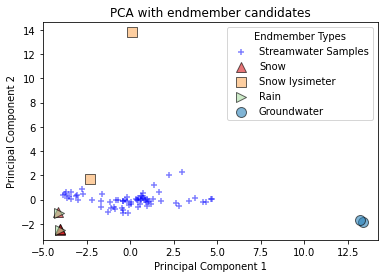

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load streamwater data from the CSV file
streamwater_data = pd.read_csv("data/Data_for_EMMA_2022_HB.csv")

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_streamwater = streamwater_data[selected_parameters]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(subset_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for an EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)
pca_2Dresult_streamwater.to_csv("analysis/pca_result_streamwater.csv", index=False, header=True)

# Add a column for the event based on the date
# streamwater_data.loc[(streamwater_data['Date'] >= '2022-02-02') & (streamwater_data['Date'] <= '2022-02-16'), 'Event'] = 'Event A'
# streamwater_data.loc[(streamwater_data['Date'] >= '2022-03-05') & (streamwater_data['Date'] <= '2022-03-10'), 'Event'] = 'Event B'
# streamwater_data.loc[(streamwater_data['Date'] >= '2022-03-16') & (streamwater_data['Date'] <= '2022-03-22'), 'Event'] = 'Event C'
# streamwater_data.loc[(streamwater_data['Date'] >= '2022-04-07') & (streamwater_data['Date'] <= '2022-04-11'), 'Event'] = 'Event D'

# Define colors for each event
event_colors = {'Event A': 'blue', 'Event B': 'blue', 'Event C': 'blue', 'Event D': 'blue'}

# Plot streamwater PCA results with blue '+' markers
plt.scatter(pca_result_streamwater[:, 0], pca_result_streamwater[:, 1], marker='+', c='blue', alpha=0.5, label='Streamwater Samples')

# Add a legend for streamwater samples
handles_streamwater = [plt.Line2D([0], [0], marker='+', color='w', label='Streamwater Samples',
                                  markerfacecolor='blue', markersize=10)]
plt.legend(handles=handles_streamwater)

# Load potential endmembers from the separate CSV file
endmember_data = pd.read_csv("data/end_members_2022_HB.csv")

# Convert the 'Date' column to datetime in the endmember data
endmember_data['Date'] = pd.to_datetime(endmember_data['Date'], format='%m/%d/%y')

# Extract the subset of data for selected parameters in endmembers
subset_endmembers = endmember_data[selected_parameters]

# Handle missing values in endmembers (replace with mean)
subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())

# Standardize the endmember data (mean=0 and variance=1)
scaled_endmembers = scaler.transform(subset_endmembers)

# Apply PCA to endmember data
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

# Define a dictionary to map 'Type' to marker shape
marker_shapes = {'Groundwater': 'o', 'Snow lysimeter': 's', 'Snow': '^', 'Rain': '>'}

# Plot all potential endmembers with colored markers and different shapes
for event_type, color in zip(endmember_data['Type'].unique(), ['#d7191c', '#fdae61', '#abdda4', '#2b83ba']):
    indices = endmember_data['Type'] == event_type
    plt.scatter(pca_result_endmembers[indices, 0], pca_result_endmembers[indices, 1], marker=marker_shapes[event_type],
                c=color, alpha=0.60, label=event_type, edgecolors="black", s=100)

# Add a legend for endmember types
plt.legend(title='Endmember Types')

plt.title('PCA with endmember candidates')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


### I want to look at the candidate endmembers in lineplot form for the 5 tracers; clearly the snow lysimters are quite different (they are high in all tracers, looking at the raw data).

### Now we make a selection of endmembers based on the projected data above. We want 3 EMs, and will construct them from:

1. Precipitation (mean of all snow and rain EM samples)​

2. Snow lysimeter (mean of the snow lysimeter samples)​

3. Groundwater (mean of the groundwater samples)

### Let's now project the mean EMs onto the PC1 vs PC2 space:

Percentage of points within the triangle: 100.00%


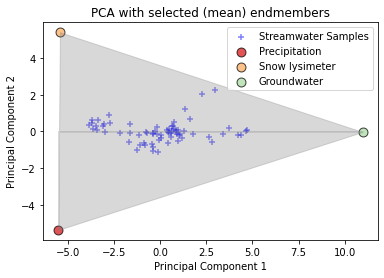

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.path import Path
import numpy as np

# Load streamwater data from the CSV file
streamwater_data = pd.read_csv("data/Data_for_EMMA_2022_HB.csv")

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters
subset_streamwater = streamwater_data[selected_parameters]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(subset_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Load potential endmembers from the separate CSV file
endmember_data = pd.read_csv("data/end_members_2022_HB_mean_for_emma.csv")

# Extract the subset of data for selected parameters in endmembers
subset_endmembers = endmember_data[selected_parameters]

# Handle missing values in endmembers (replace with mean)
subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())

# Standardize the endmember data (mean=0 and variance=1)
scaled_endmembers = scaler.transform(subset_endmembers)

# Apply PCA to endmember data
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

# Define vertices of the triangle formed by endmembers
triangle_vertices = pca_result_endmembers[:, :2]

# Create a Path object representing the triangle
triangle_path = Path(triangle_vertices)

# Check which points in streamwater data are within the triangle
points_within_triangle = triangle_path.contains_points(pca_result_streamwater)

# Calculate the percentage of points within the triangle
percentage_within_triangle = sum(points_within_triangle) / len(points_within_triangle) * 100

print(f"Percentage of points within the triangle: {percentage_within_triangle:.2f}%")

# Plot streamwater PCA results with blue '+' markers
plt.scatter(pca_result_streamwater[:, 0], pca_result_streamwater[:, 1], marker='+', c='blue', alpha=0.5, label='Streamwater Samples')

# Explicitly define the vertices in counterclockwise order
triangle_path = Path(np.array([[triangle_vertices[0, 0], triangle_vertices[0, 1]],
                                [triangle_vertices[1, 0], triangle_vertices[1, 1]],
                                [triangle_vertices[2, 0], triangle_vertices[2, 1]],
                                [triangle_vertices[0, 0], triangle_vertices[0, 1]]]))

xs, ys = zip(*triangle_path.vertices)

# Plot all potential endmembers with colored circle markers
for event_type, color in zip(endmember_data['Type'].unique(), ['#d7191c', '#fdae61', '#abdda4', '#2b83ba']):
    indices = endmember_data['Type'] == event_type
    plt.scatter(pca_result_endmembers[indices, 0], pca_result_endmembers[indices, 1], marker='o', c=color, \
                alpha=0.75, label=event_type, edgecolors="black", s=80)

    # Connect the endmembers with dashed lines to form a triangle
    plt.plot(pca_result_endmembers[indices, 0].tolist() + [pca_result_endmembers[indices, 0].tolist()[0]],
             pca_result_endmembers[indices, 1].tolist() + [pca_result_endmembers[indices, 1].tolist()[0]],
             linestyle='dashed', color=color)

# Add a legend for endmember types
plt.legend(title='')

# Fill the entire area below the triangle formed by the endmembers
plt.fill_between(xs, ys, color='gray', alpha=0.3)

plt.title('PCA with selected (mean) endmembers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [7]:
#define function to calculate cv
cv = lambda x: np.std(x, ddof=1) / np.mean(x)

In [8]:
precip_cl = [0.1, 0.16, 0.02, 0.1, 0.14, 0.09]

cv(precip_cl)

0.4754663618176391

## Event-specific endmembers

### Now instead of using a mean endmember suite, we want to use endmember samples that best correspond temporally with the event in question. 
- For endmember samples like groundwater, we only have March '22 and July '22 samples (which are virtually the same), so this will more impact the snowmelt lysimeter endmemers.

### There are 2 precipitation potential endmember samples that are missing Cl- measurements. To account for this, we first filter out rows from the endmember dataframe that contain NaN values in any of the selected parameters before standardizing and applying PCA. 

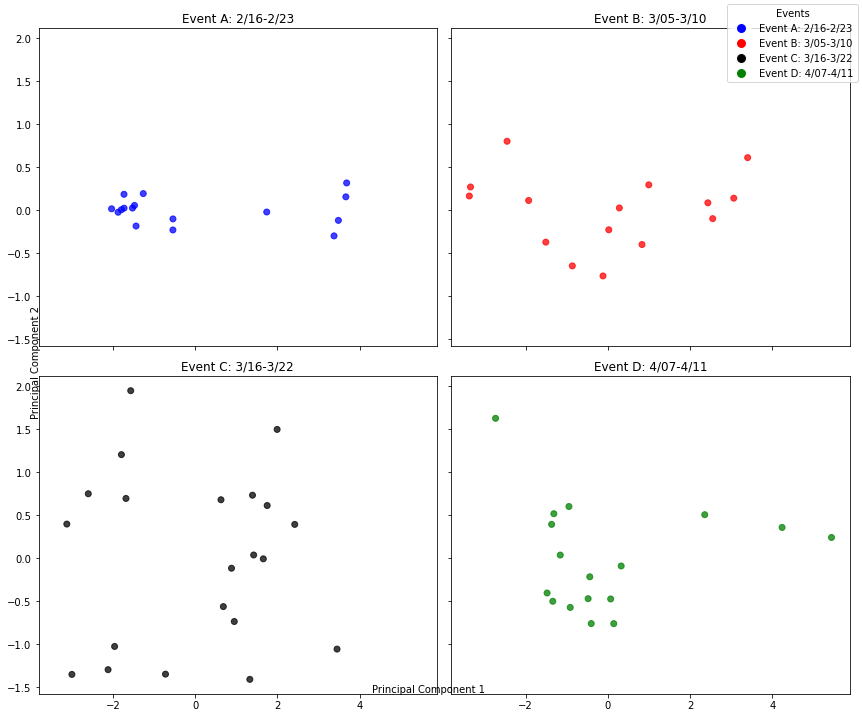

In [9]:
# First just doing event-specific PCAs and projecting streamwater data:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data from the CSV file
data = pd.read_csv("data/Data_for_EMMA_2022_HB.csv")

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')

# Add a column for the event based on the date
data['Event'] = 'Unknown'
data.loc[(data['Date'] >= '2022-02-16') & (data['Date'] <= '2022-02-23'), 'Event'] = 'Event A: 2/16-2/23'
data.loc[(data['Date'] >= '2022-03-05') & (data['Date'] <= '2022-03-10'), 'Event'] = 'Event B: 3/05-3/10'
data.loc[(data['Date'] >= '2022-03-16') & (data['Date'] <= '2022-03-22'), 'Event'] = 'Event C: 3/16-3/22'
data.loc[(data['Date'] >= '2022-04-07') & (data['Date'] <= '2022-04-11'), 'Event'] = 'Event D: 4/07-4/11'

# Define colors for each event
event_colors = {'Event A: 2/16-2/23': 'blue', 'Event B: 3/05-3/10': 'red',
                'Event C: 3/16-3/22': 'black', 'Event D: 4/07-4/11': 'green'}

# Set up subplots for each event
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Iterate over each event
for i, event in enumerate(['Event A: 2/16-2/23', 'Event B: 3/05-3/10', 'Event C: 3/16-3/22', 'Event D: 4/07-4/11']):
    # Filter data for the current event
    event_data = data[data['Event'] == event]

    # Select the specific parameters of interest
    selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

    # Extract the subset of data for selected parameters
    subset_data = event_data[selected_parameters]

    # Standardize the data (mean=0 and variance=1)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(subset_data)

    # Apply PCA
    pca = PCA(n_components=2)  # Specify the number of components
    pca_result = pca.fit_transform(scaled_data)

    # Plot PCA results with color-coded events
    colors = event_data['Event'].map(event_colors)
    axs[i // 2, i % 2].scatter(pca_result[:, 0], pca_result[:, 1], c=colors, alpha=0.75)
    axs[i // 2, i % 2].set_title(event)

# Set common labels
fig.text(0.5, 0.04, 'Principal Component 1', ha='center')
fig.text(0.04, 0.5, 'Principal Component 2', va='center', rotation='vertical')

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=event,
                      markerfacecolor=color, markersize=10)
           for event, color in event_colors.items()]
fig.legend(handles=handles, loc='upper right', title='Events')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

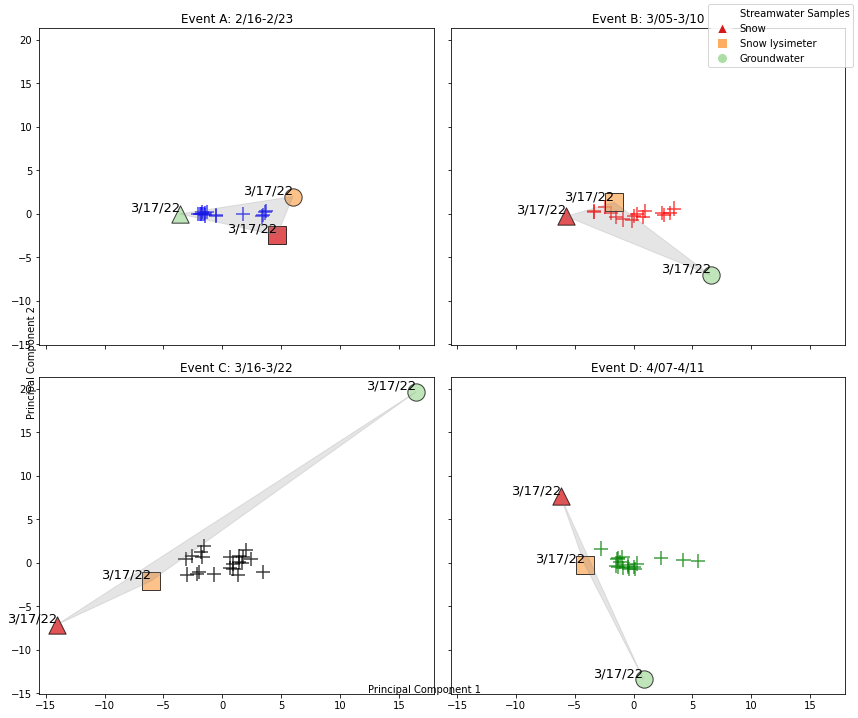

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Polygon

np.set_printoptions(precision=4)

# Load the streamwater data from the CSV file
streamwater_data = pd.read_csv("data/Data_for_EMMA_2022_HB.csv")

# Convert the 'Date' column to datetime
streamwater_data['Date'] = pd.to_datetime(streamwater_data['Date'], format='%m/%d/%y')

# Add a column for the event based on the date
streamwater_data['Event'] = 'Unknown'
streamwater_data.loc[(streamwater_data['Date'] >= '2022-02-16') & (streamwater_data['Date'] <= '2022-02-23'), 'Event'] = 'Event A: 2/16-2/23'
streamwater_data.loc[(streamwater_data['Date'] >= '2022-03-05') & (streamwater_data['Date'] <= '2022-03-10'), 'Event'] = 'Event B: 3/05-3/10'
streamwater_data.loc[(streamwater_data['Date'] >= '2022-03-16') & (streamwater_data['Date'] <= '2022-03-22'), 'Event'] = 'Event C: 3/16-3/22'
streamwater_data.loc[(streamwater_data['Date'] >= '2022-04-07') & (streamwater_data['Date'] <= '2022-04-11'), 'Event'] = 'Event D: 4/07-4/11'

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Define colors for each event
event_colors = {'Event A: 2/16-2/23': 'blue', 'Event B: 3/05-3/10': 'red',
                'Event C: 3/16-3/22': 'black', 'Event D: 4/07-4/11': 'green'}

# Define marker shapes for each endmember type
marker_shapes = {'Groundwater': 'o', 'Snow lysimeter': 's', 'Snow': '^', 'Rain': '>'}

# Set up subplots for each event
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Iterate over each event
for i, event in enumerate(['Event A: 2/16-2/23', 'Event B: 3/05-3/10', 'Event C: 3/16-3/22', 'Event D: 4/07-4/11']):
    # Filter streamwater data for the current event
    event_streamwater_data = streamwater_data[streamwater_data['Event'] == event]

    # Select the subset of data for selected parameters
    subset_streamwater = event_streamwater_data[selected_parameters]

    # Standardize the streamwater data (mean=0 and variance=1)
    scaler = StandardScaler()
    scaled_streamwater = scaler.fit_transform(subset_streamwater)

    # Apply PCA to streamwater data
    pca_streamwater = PCA(n_components=2)
    pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

    # Plot PCA results of streamwater samples
    colors = event_streamwater_data['Event'].map(event_colors)
    axs[i // 2, i % 2].scatter(pca_result_streamwater[:, 0], pca_result_streamwater[:, 1],
                               marker='+', c=colors, alpha=0.75, s=200, label='Streamwater Samples')

    # Load endmember data for the current event
    endmember_data = pd.read_csv(f"data/end_members_2022_HB_event{'ABCD'[i]}.csv")  # Assumes file naming convention

    # Select the subset of data for selected parameters
    subset_endmember = endmember_data[selected_parameters]

    # Standardize the endmember data using the scaler fitted on streamwater data
    scaled_endmember = scaler.transform(subset_endmember)

    # Transform endmember data using the PCA transformation matrix of the current event
    pca_result_endmember = pca_streamwater.transform(scaled_endmember)

    # Plot endmember data in the event-specific PCA space
    for event_type, color in zip(endmember_data['Type'].unique(), ['#d7191c', '#fdae61', '#abdda4', '#2b83ba']):
        indices = endmember_data['Type'] == event_type
        axs[i // 2, i % 2].scatter(pca_result_endmember[indices, 0], pca_result_endmember[indices, 1],
                                   marker=marker_shapes[event_type], c=color, edgecolors='black', alpha=0.75, s=300, label=event_type)
        
        # Add date labels for endmember data points
        for j, txt in enumerate(labels[indices]):
            axs[i // 2, i % 2].text(pca_result_endmember[indices, 0][j], pca_result_endmember[indices, 1][j], txt,
                                     fontsize=13, ha='right', va='bottom', color='black')

    # Shade the area bounded by the endmembers
    endmember_polygon = Polygon(pca_result_endmember[:, :2], closed=True, color='gray', alpha=0.2)
    axs[i // 2, i % 2].add_patch(endmember_polygon)

    # Calculate the percentage of streamwater data bounded by the endmembers
    bounded_percentage = sum((pca_result_streamwater[:, :2] >= pca_result_endmember.min(axis=0)) & (
            pca_result_streamwater[:, :2] <= pca_result_endmember.max(axis=0))) / len(pca_result_streamwater) * 100

    # Print the percentage in the upper left corner of each subplot
    #axs[i // 2, i % 2].text(0.05, 0.95, f'{bounded_percentage:.2f}% streamwater data bounded', transform=axs[i // 2, i % 2].transAxes, fontsize=10,
                           #verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
        
    # Set subplot title
    axs[i // 2, i % 2].set_title(event)

# Set common labels
fig.text(0.5, 0.04, 'Principal Component 1', ha='center')
fig.text(0.04, 0.5, 'Principal Component 2', va='center', rotation='vertical')

# Add legends
handles_streamwater = [plt.Line2D([0], [0], marker='+', color='w', label='Streamwater Samples',
                                  markerfacecolor='blue', markersize=10)]
handles_endmember = [plt.Line2D([0], [0], marker=marker_shapes[event_type], color='w', label=event_type,
                                markerfacecolor=color, markersize=10)
                     for event_type, color in zip(endmember_data['Type'].unique(), ['#d7191c', '#fdae61', '#abdda4', '#2b83ba'])]

fig.legend(handles=handles_streamwater + handles_endmember, loc='upper right', title='')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

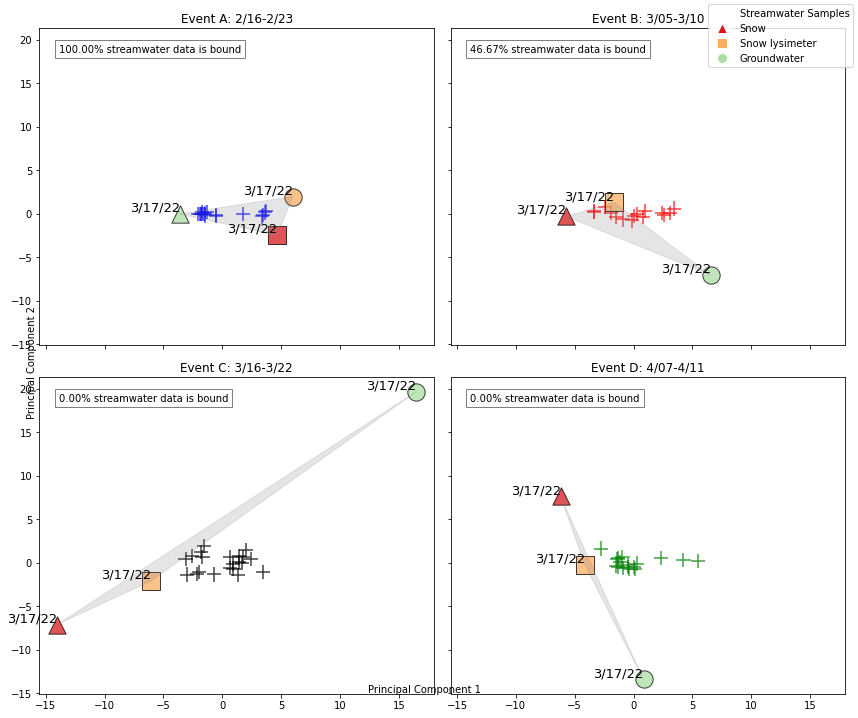

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Polygon
from matplotlib.path import Path

np.set_printoptions(precision=4)

# Load the streamwater data from the CSV file
streamwater_data = pd.read_csv("data/Data_for_EMMA_2022_HB.csv")

# Convert the 'Date' column to datetime
streamwater_data['Date'] = pd.to_datetime(streamwater_data['Date'], format='%m/%d/%y')

# Add a column for the event based on the date
streamwater_data['Event'] = 'Unknown'
streamwater_data.loc[(streamwater_data['Date'] >= '2022-02-16') & (streamwater_data['Date'] <= '2022-02-23'), 'Event'] = 'Event A: 2/16-2/23'
streamwater_data.loc[(streamwater_data['Date'] >= '2022-03-05') & (streamwater_data['Date'] <= '2022-03-10'), 'Event'] = 'Event B: 3/05-3/10'
streamwater_data.loc[(streamwater_data['Date'] >= '2022-03-16') & (streamwater_data['Date'] <= '2022-03-22'), 'Event'] = 'Event C: 3/16-3/22'
streamwater_data.loc[(streamwater_data['Date'] >= '2022-04-07') & (streamwater_data['Date'] <= '2022-04-11'), 'Event'] = 'Event D: 4/07-4/11'

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Define colors for each event
event_colors = {'Event A: 2/16-2/23': 'blue', 'Event B: 3/05-3/10': 'red',
                'Event C: 3/16-3/22': 'black', 'Event D: 4/07-4/11': 'green'}

# Define marker shapes for each endmember type
marker_shapes = {'Groundwater': 'o', 'Snow lysimeter': 's', 'Snow': '^', 'Rain': '>'}

# Set up subplots for each event
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Iterate over each event
for i, event in enumerate(['Event A: 2/16-2/23', 'Event B: 3/05-3/10', 'Event C: 3/16-3/22', 'Event D: 4/07-4/11']):
    # Filter streamwater data for the current event
    event_streamwater_data = streamwater_data[streamwater_data['Event'] == event]

    # Select the subset of data for selected parameters
    subset_streamwater = event_streamwater_data[selected_parameters]

    # Standardize the streamwater data (mean=0 and variance=1)
    scaler = StandardScaler()
    scaled_streamwater = scaler.fit_transform(subset_streamwater)

    # Apply PCA to streamwater data
    pca_streamwater = PCA(n_components=2)
    pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

    # Plot PCA results of streamwater samples
    colors = event_streamwater_data['Event'].map(event_colors)
    axs[i // 2, i % 2].scatter(pca_result_streamwater[:, 0], pca_result_streamwater[:, 1],
                               marker='+', c=colors, alpha=0.75, s=200, label='Streamwater Samples')

    # Load endmember data for the current event
    endmember_data = pd.read_csv(f"data/end_members_2022_HB_event{'ABCD'[i]}.csv")  # Assumes file naming convention

    # Select the subset of data for selected parameters
    subset_endmember = endmember_data[selected_parameters]

    # Standardize the endmember data using the scaler fitted on streamwater data
    scaled_endmember = scaler.transform(subset_endmember)

    # Transform endmember data using the PCA transformation matrix of the current event
    pca_result_endmember = pca_streamwater.transform(scaled_endmember)

    # Plot endmember data in the event-specific PCA space
    for event_type, color in zip(endmember_data['Type'].unique(), ['#d7191c', '#fdae61', '#abdda4', '#2b83ba']):
        indices = endmember_data['Type'] == event_type
        axs[i // 2, i % 2].scatter(pca_result_endmember[indices, 0], pca_result_endmember[indices, 1],
                                   marker=marker_shapes[event_type], c=color, edgecolors='black', alpha=0.75, s=300, label=event_type)
        
        # Add date labels for endmember data points
        for j, txt in enumerate(labels[indices]):
            axs[i // 2, i % 2].text(pca_result_endmember[indices, 0][j], pca_result_endmember[indices, 1][j], txt,
                                     fontsize=13, ha='right', va='bottom', color='black')

    # Define the vertices of the triangle formed by the endmembers
    triangle_vertices = pca_result_endmember[:, :2]

    # Create a Path object representing the triangle
    triangle_path = Path(triangle_vertices)

    # Check which points in streamwater data are within the triangle
    points_within_triangle = triangle_path.contains_points(pca_result_streamwater[:, :2])

    # Calculate the percentage of points within the triangle
    bounded_percentage = (sum(points_within_triangle) / len(points_within_triangle)) * 100

    # Print the percentage in the upper left corner of each subplot
    axs[i // 2, i % 2].text(0.05, 0.95, f'{bounded_percentage:.2f}% streamwater data is bound', transform=axs[i // 2, i % 2].transAxes, fontsize=10,
                       verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    
    # Shade the area bounded by the endmembers
    endmember_polygon = Polygon(pca_result_endmember[:, :2], closed=True, color='gray', alpha=0.2)
    axs[i // 2, i % 2].add_patch(endmember_polygon)
        
    # Set subplot title
    axs[i // 2, i % 2].set_title(event)

# Set common labels
fig.text(0.5, 0.04, 'Principal Component 1', ha='center')
fig.text(0.04, 0.5, 'Principal Component 2', va='center', rotation='vertical')

# Add legends
handles_streamwater = [plt.Line2D([0], [0], marker='+', color='w', label='Streamwater Samples',
                                  markerfacecolor='blue', markersize=10)]
handles_endmember = [plt.Line2D([0], [0], marker=marker_shapes[event_type], color='w', label=event_type,
                                markerfacecolor=color, markersize=10)
                     for event_type, color in zip(endmember_data['Type'].unique(), ['#d7191c', '#fdae61', '#abdda4', '#2b83ba'])]

fig.legend(handles=handles_streamwater + handles_endmember, loc='upper right', title='')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()